In [8]:
import pandas as pd
import pathlib
import keras
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [9]:
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.metrics import BinaryAccuracy, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [10]:
from oauth2client.client import GoogleCredentials

from google.colab import auth as google_auth
google_auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
shared_folder_link = 'https://drive.google.com/drive/folders/1rLvDKk8tzdTHRLVSWs6uWBb9SKSQS15z?usp=sharing'

In [5]:
data_folder = '/content/gdrive/MyDrive/medical_aimaging/data'

# Brain Diseases Comparison

In [6]:
url_normal = '/content/gdrive/MyDrive/medical_aimaging/data/MR/brain/normal/'

url_acute = '/content/gdrive/MyDrive/medical_aimaging/data/MR/brain/acute_infarct/'
url_chronic = '/content/gdrive/MyDrive/medical_aimaging/data/MR/brain/chronic_infarct/'
url_extra = '/content/gdrive/MyDrive/medical_aimaging/data/MR/brain/extra/'
url_ffh = '/content/gdrive/MyDrive/medical_aimaging/data/MR/brain/focal_flair_hyper/'
url_intra = '/content/gdrive/MyDrive/medical_aimaging/data/MR/brain/intra/'
url_wmc = '/content/gdrive/MyDrive/medical_aimaging/data/MR/brain/white_matter_changes/'


In [7]:
limit = 333

In [8]:
images_normal = [cv2.imread(file) for file in glob.glob(url_normal+"*.png")][:limit]

In [9]:
images_acute = [cv2.imread(file) for file in glob.glob(url_acute+"*.png")][:limit]
images_chronic = [cv2.imread(file) for file in glob.glob(url_chronic+"*.png")][:limit]
images_extra = [cv2.imread(file) for file in glob.glob(url_extra+"*.png")][:limit]
images_ffh = [cv2.imread(file) for file in glob.glob(url_ffh+"*.png")][:limit]
images_intra = [cv2.imread(file) for file in glob.glob(url_intra+"*.png")][:limit]
images_wmc = [cv2.imread(file) for file in glob.glob(url_wmc+"*.png")][:limit]

In [10]:
labels_acute = [2] * len(images_acute)
labels_chronic = [3] * len(images_chronic)
labels_extra = [4] * len(images_extra)
labels_ffh = [1] * len(images_ffh)
labels_intra = [5] * len(images_intra)
labels_wmc = [5] * len(images_wmc)


labels_normal = [0] * len(images_normal)

In [11]:
normal_count = len(images_normal)
normal_count

333

In [12]:
print(len(images_normal))
print(len(images_acute))
print(len(images_chronic))
print(len(images_extra))
print(len(images_ffh))
print(len(images_intra))
print(len(images_wmc))

333
333
333
333
333
333
333


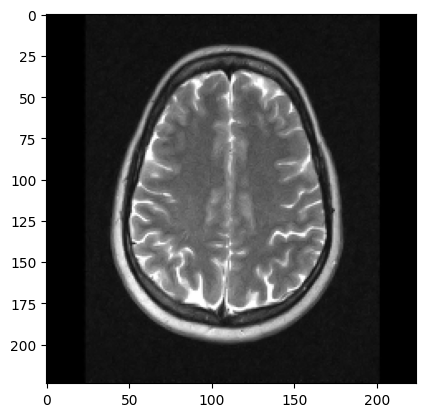

In [13]:
img = np.asarray(images_normal[0])
imgplot = plt.imshow(img)

In [14]:
def initialize_vgg16_model():

        metrics = [BinaryAccuracy(name='binary_accuracy'), Recall(name='recall')]

        input_shape = (224, 224, 3)
        num_classes=1

        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

        for layer in base_model.layers:
            layer.trainable = False

        model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='sigmoid')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

        return model

In [15]:
model = initialize_vgg16_model()
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27560769 (105.14 MB)
Trainable params: 12846081 (49.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# Creating X and y for training and testing

In [16]:
labels_intra = [0] * len(images_intra)
labels_wmc = [1] * len(images_wmc)

In [17]:
X = np.concatenate((images_intra, images_wmc), axis=0)
y = np.concatenate((labels_intra, labels_wmc), axis=0)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [19]:
X_train.shape

(532, 224, 224, 3)

In [20]:
y_train.shape

(532,)

# Training the model

In [21]:
model = initialize_vgg16_model()

In [22]:
es = EarlyStopping(patience = 10, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

Epoch 1/50
14/14 [==============================] - 20s 481ms/step - loss: 39.8037 - binary_accuracy: 0.6235 - recall: 0.6157 - val_loss: 9.2619 - val_binary_accuracy: 0.7103 - val_recall: 0.9630
Epoch 2/50
14/14 [==============================] - 2s 167ms/step - loss: 2.5659 - binary_accuracy: 0.8282 - recall: 0.8380 - val_loss: 1.6545 - val_binary_accuracy: 0.8411 - val_recall: 0.9444
Epoch 3/50
14/14 [==============================] - 2s 148ms/step - loss: 0.3168 - binary_accuracy: 0.9082 - recall: 0.9213 - val_loss: 0.6344 - val_binary_accuracy: 0.8131 - val_recall: 0.7037
Epoch 4/50
14/14 [==============================] - 2s 167ms/step - loss: 0.1273 - binary_accuracy: 0.9435 - recall: 0.9306 - val_loss: 0.5637 - val_binary_accuracy: 0.8505 - val_recall: 0.8519
Epoch 5/50
14/14 [==============================] - 2s 168ms/step - loss: 0.0401 - binary_accuracy: 0.9812 - recall: 0.9769 - val_loss: 0.4246 - val_binary_accuracy: 0.8972 - val_recall: 0.9259
Epoch 6/50
14/14 [==========

In [15]:
def plot_loss_accuracy(history, title=None):
        fig, ax = plt.subplots(1,3, figsize=(20,7))

        # --- LOSS ---

        ax[0].plot(history.history['loss'])
        ax[0].plot(history.history['val_loss'])
        ax[0].set_title('Model loss')
        ax[0].set_ylabel('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylim((0,3))
        ax[0].legend(['Train', 'Validation'], loc='best')
        ax[0].grid(axis="x",linewidth=0.5)
        ax[0].grid(axis="y",linewidth=0.5)

        # --- ACCURACY

        ax[1].plot(history.history['binary_accuracy'])
        ax[1].plot(history.history['val_binary_accuracy'])
        ax[1].set_title('Model Accuracy')
        ax[1].set_ylabel('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].legend(['Train', 'Validation'], loc='best')
        ax[1].set_ylim((0,1))
        ax[1].grid(axis="x",linewidth=0.5)
        ax[1].grid(axis="y",linewidth=0.5)

        # --- RECALL

        ax[2].plot(history.history['recall'])
        ax[2].plot(history.history['val_recall'])
        ax[2].set_title('Model Recall')
        ax[2].set_ylabel('Recall')
        ax[2].set_xlabel('Epoch')
        ax[2].legend(['Train', 'Validation'], loc='best')
        ax[2].set_ylim((0,1))
        ax[2].grid(axis="x",linewidth=0.5)
        ax[2].grid(axis="y",linewidth=0.5)

        if title:
            fig.suptitle(title)

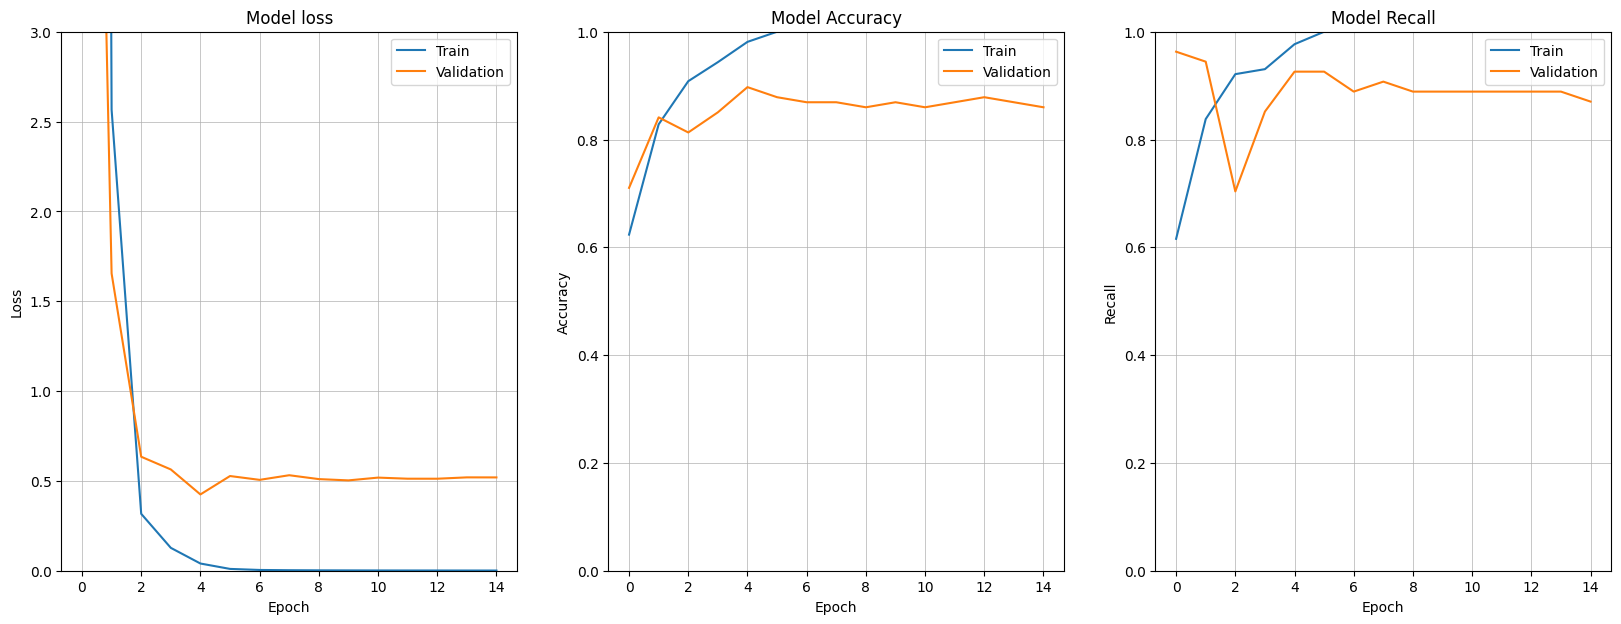

In [24]:
plot_loss_accuracy(history, title=None)

In [25]:
evaluation = model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 330ms/step - loss: 0.5493 - binary_accuracy: 0.8806 - recall: 0.8571


In [26]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')

Model accuracy is 88.06 %
Model recall is 85.71 %


# Lung Diseases Comparison

In [42]:
url_normal = '/content/gdrive/MyDrive/medical_aimaging/data/CT/lung/normal/'

url_airspace = '/content/gdrive/MyDrive/medical_aimaging/data/CT/lung/Airspace_opacity/'
url_bronch = '/content/gdrive/MyDrive/medical_aimaging/data/CT/lung/Bronchiectasis/'
url_nodule = '/content/gdrive/MyDrive/medical_aimaging/data/CT/lung/Nodule/'
url_parenchyma = '/content/gdrive/MyDrive/medical_aimaging/data/CT/lung/Parenchyma_destruction/'
url_inter = '/content/gdrive/MyDrive/medical_aimaging/data/CT/lung/interstitial_lung_disease/'


In [43]:
limit = 500
images_normal = [cv2.imread(file) for file in glob.glob(url_normal+"*.png")][:limit]

images_airspace = [cv2.imread(file) for file in glob.glob(url_airspace+"*.png")][:limit]
images_bronch = [cv2.imread(file) for file in glob.glob(url_bronch+"*.png")][:limit]
images_inter = [cv2.imread(file) for file in glob.glob(url_inter+"*.png")][:limit]
images_nodule = [cv2.imread(file) for file in glob.glob(url_nodule+"*.png")][:limit]
images_parenchyma = [cv2.imread(file) for file in glob.glob(url_parenchyma+"*.png")][:limit]

In [44]:
labels_airspace = [1] * len(images_airspace)
labels_bronch = [2] * len(images_bronch)
labels_inter = [3] * len(images_inter)
labels_nodule = [4] * len(images_nodule)
labels_parenchyma = [5] * len(images_parenchyma)

labels_normal = [0] * len(images_normal)

In [46]:
print(len(images_normal))
print(len(images_airspace))
print(len(images_bronch))
print(len(images_inter))
print(len(images_nodule))
print(len(images_parenchyma))

500
500
500
500
500
500


## Testing Normal vs Every diseases

In [81]:
labels_normal = [0] * len(images_normal)
labels_bronch = [1] * len(images_bronch)

In [82]:
X = np.concatenate((images_normal, images_bronch), axis=0)
y = np.concatenate((labels_normal, labels_bronch), axis=0)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(800, 224, 224, 3)
(800,)


In [78]:
model = initialize_vgg16_model()
es = EarlyStopping(patience = 10, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

Epoch 1/50
20/20 [==============================] - 5s 179ms/step - loss: 21.9195 - binary_accuracy: 0.8422 - recall: 0.8426 - val_loss: 4.1273 - val_binary_accuracy: 0.9438 - val_recall: 0.9583
Epoch 2/50
20/20 [==============================] - 3s 156ms/step - loss: 1.4438 - binary_accuracy: 0.9766 - recall: 0.9753 - val_loss: 5.7822 - val_binary_accuracy: 0.9500 - val_recall: 1.0000
Epoch 3/50
20/20 [==============================] - 3s 161ms/step - loss: 0.3977 - binary_accuracy: 0.9875 - recall: 0.9877 - val_loss: 4.2242 - val_binary_accuracy: 0.9438 - val_recall: 0.9583
Epoch 4/50
20/20 [==============================] - 3s 168ms/step - loss: 0.3913 - binary_accuracy: 0.9859 - recall: 0.9877 - val_loss: 3.2453 - val_binary_accuracy: 0.9375 - val_recall: 0.9306
Epoch 5/50
20/20 [==============================] - 3s 161ms/step - loss: 0.0532 - binary_accuracy: 0.9984 - recall: 1.0000 - val_loss: 5.3301 - val_binary_accuracy: 0.9563 - val_recall: 1.0000
Epoch 6/50
20/20 [===========

7/7 [==============================] - 1s 109ms/step - loss: 3.3532 - binary_accuracy: 0.9450 - recall: 0.9519


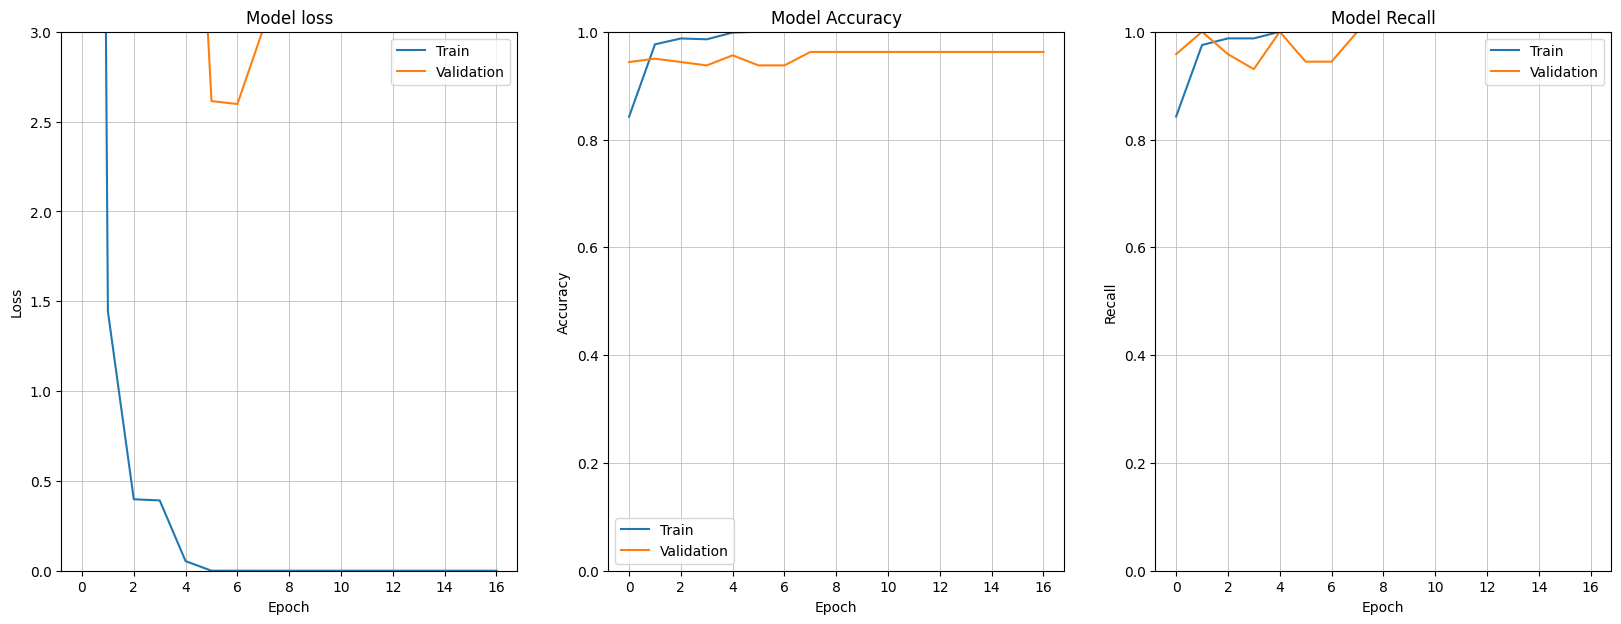

In [79]:
plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

In [80]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')

Model accuracy is 94.5 %
Model recall is 95.19 %


## Testing disease vs disease

In [120]:
labels_nodule = [0] * len(images_nodule)
labels_parenchyma = [1] * len(images_parenchyma)
X = np.concatenate((images_nodule, images_parenchyma), axis=0)
y = np.concatenate((labels_nodule, labels_parenchyma), axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(800, 224, 224, 3)
(800,)


In [121]:
model = initialize_vgg16_model()
es = EarlyStopping(patience = 10, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

Epoch 1/50
20/20 [==============================] - 5s 183ms/step - loss: 46.0486 - binary_accuracy: 0.5406 - recall: 0.5401 - val_loss: 2.2667 - val_binary_accuracy: 0.6313 - val_recall: 0.9167
Epoch 2/50
20/20 [==============================] - 3s 158ms/step - loss: 1.0725 - binary_accuracy: 0.7484 - recall: 0.7932 - val_loss: 0.9053 - val_binary_accuracy: 0.7312 - val_recall: 0.7500
Epoch 3/50
20/20 [==============================] - 3s 159ms/step - loss: 0.4245 - binary_accuracy: 0.8078 - recall: 0.7901 - val_loss: 0.6074 - val_binary_accuracy: 0.6938 - val_recall: 0.5417
Epoch 4/50
20/20 [==============================] - 3s 156ms/step - loss: 0.2153 - binary_accuracy: 0.9125 - recall: 0.8796 - val_loss: 0.7351 - val_binary_accuracy: 0.7563 - val_recall: 0.8056
Epoch 5/50
20/20 [==============================] - 3s 155ms/step - loss: 0.1409 - binary_accuracy: 0.9578 - recall: 0.9444 - val_loss: 0.7728 - val_binary_accuracy: 0.7437 - val_recall: 0.8611
Epoch 6/50
20/20 [===========

7/7 [==============================] - 1s 109ms/step - loss: 0.7507 - binary_accuracy: 0.6350 - recall: 0.4808


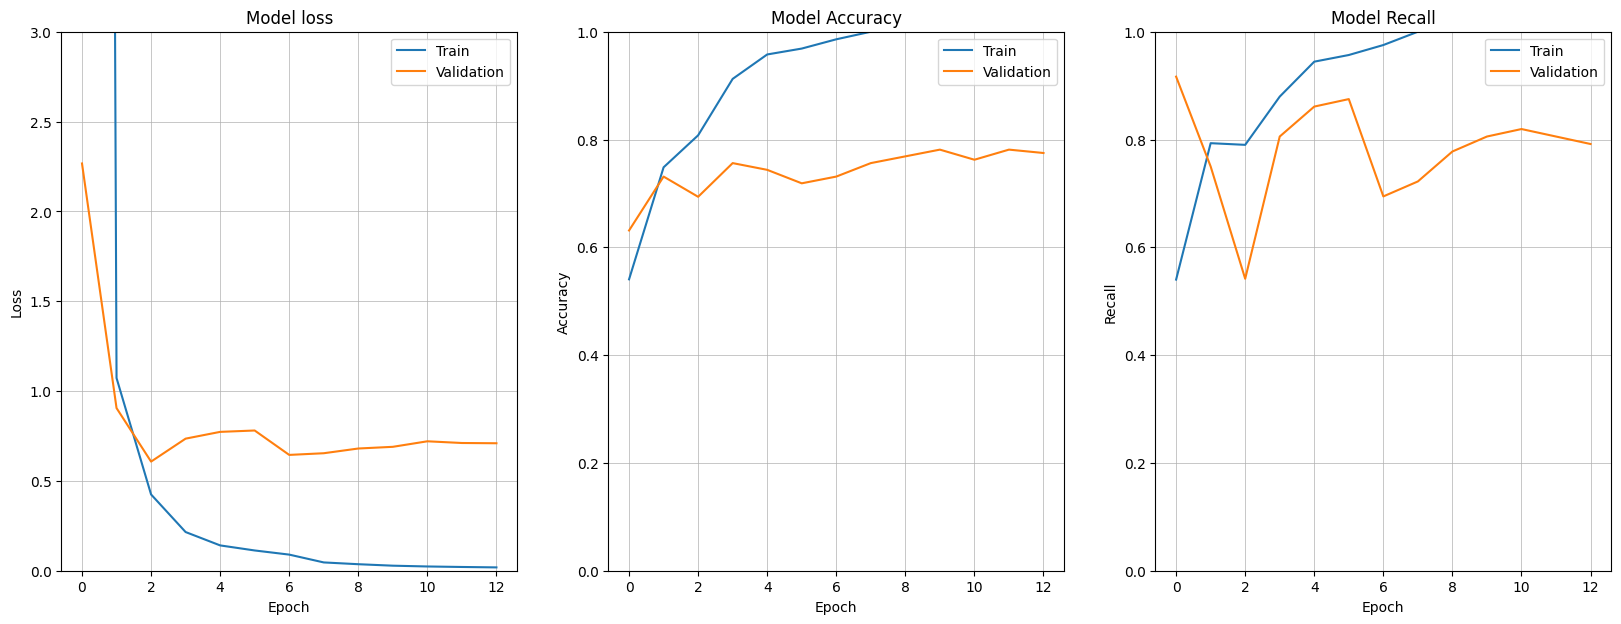

In [122]:
plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

In [123]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')

Model accuracy is 63.5 %
Model recall is 48.08 %


# Knee Diseases Comparison

In [11]:
url_normal = '/content/gdrive/MyDrive/medical_aimaging/data/MR/knee/normal/'

url_acl = '/content/gdrive/MyDrive/medical_aimaging/data/MR/knee/acl_pathology/'
url_inflammation = '/content/gdrive/MyDrive/medical_aimaging/data/MR/knee/bone_inflammation/'
url_chondral = '/content/gdrive/MyDrive/medical_aimaging/data/MR/knee/chondral_abnormality/'
url_fracture = '/content/gdrive/MyDrive/medical_aimaging/data/MR/knee/fracture/'
url_intra = '/content/gdrive/MyDrive/medical_aimaging/data/MR/knee/intra/'
url_meniscal = '/content/gdrive/MyDrive/medical_aimaging/data/MR/knee/meniscal_abnormality/'
url_patella = '/content/gdrive/MyDrive/medical_aimaging/data/MR/knee/patella_pathology/'
url_pcl = '/content/gdrive/MyDrive/medical_aimaging/data/MR/knee/pcl_pathology/'
url_stfc = '/content/gdrive/MyDrive/medical_aimaging/data/MR/knee/soft_tissue_fluid_collection/'




In [18]:
limit = 250
images_normal = [cv2.imread(file) for file in glob.glob(url_normal+"*.png")][:limit]

images_acl = [cv2.imread(file) for file in glob.glob(url_acl+"*.png")][:limit]
images_inflammation = [cv2.imread(file) for file in glob.glob(url_inflammation+"*.png")][:limit]
images_chondral = [cv2.imread(file) for file in glob.glob(url_chondral+"*.png")][:limit]
images_fracture = [cv2.imread(file) for file in glob.glob(url_fracture+"*.png")][:limit]
images_intra = [cv2.imread(file) for file in glob.glob(url_intra+"*.png")][:limit]
images_meniscal = [cv2.imread(file) for file in glob.glob(url_meniscal+"*.png")][:limit]
images_patella = [cv2.imread(file) for file in glob.glob(url_patella+"*.png")][:limit]
images_pcl = [cv2.imread(file) for file in glob.glob(url_pcl+"*.png")][:limit]
images_stfc = [cv2.imread(file) for file in glob.glob(url_stfc+"*.png")][:limit]

print(len(images_normal))
print(len(images_acl))
print(len(images_inflammation))
print(len(images_chondral))
print(len(images_fracture))
print(len(images_intra))
print(len(images_meniscal))
print(len(images_patella))
print(len(images_pcl))
print(len(images_stfc))


250
250
250
250
250
250
250
250
250
250


In [127]:
labels_acl = [1] * len(images_acl)
labels_inflammation = [2] * len(images_inflammation)
labels_chondral = [3] * len(images_chondral)
labels_fracture = [4] * len(images_fracture)
labels_intra = [5] * len(images_intra)
labels_meniscal = [6] * len(images_meniscal)
labels_patella = [7] * len(images_patella)
labels_pcl = [8] * len(images_pcl)
labels_stfc = [9] * len(images_stfc)

labels_normal = [0] * len(images_normal)

In [128]:
X = np.concatenate((images_normal, images_acl, images_inflammation, images_chondral, images_fracture, images_intra, images_meniscal, images_patella, images_pcl, images_stfc), axis=0)
y = np.concatenate((labels_normal, labels_acl, labels_inflammation, labels_chondral, labels_fracture, labels_intra, labels_meniscal, labels_patella, labels_pcl, labels_stfc), axis=0)


In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(4000, 224, 224, 3)
(4000,)


In [ ]:
model = initialize_vgg16_model()
es = EarlyStopping(patience = 10, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

32/32 [==============================] - 4s 118ms/step - loss: -2225145600.0000 - binary_accuracy: 0.1050 - recall: 1.0000


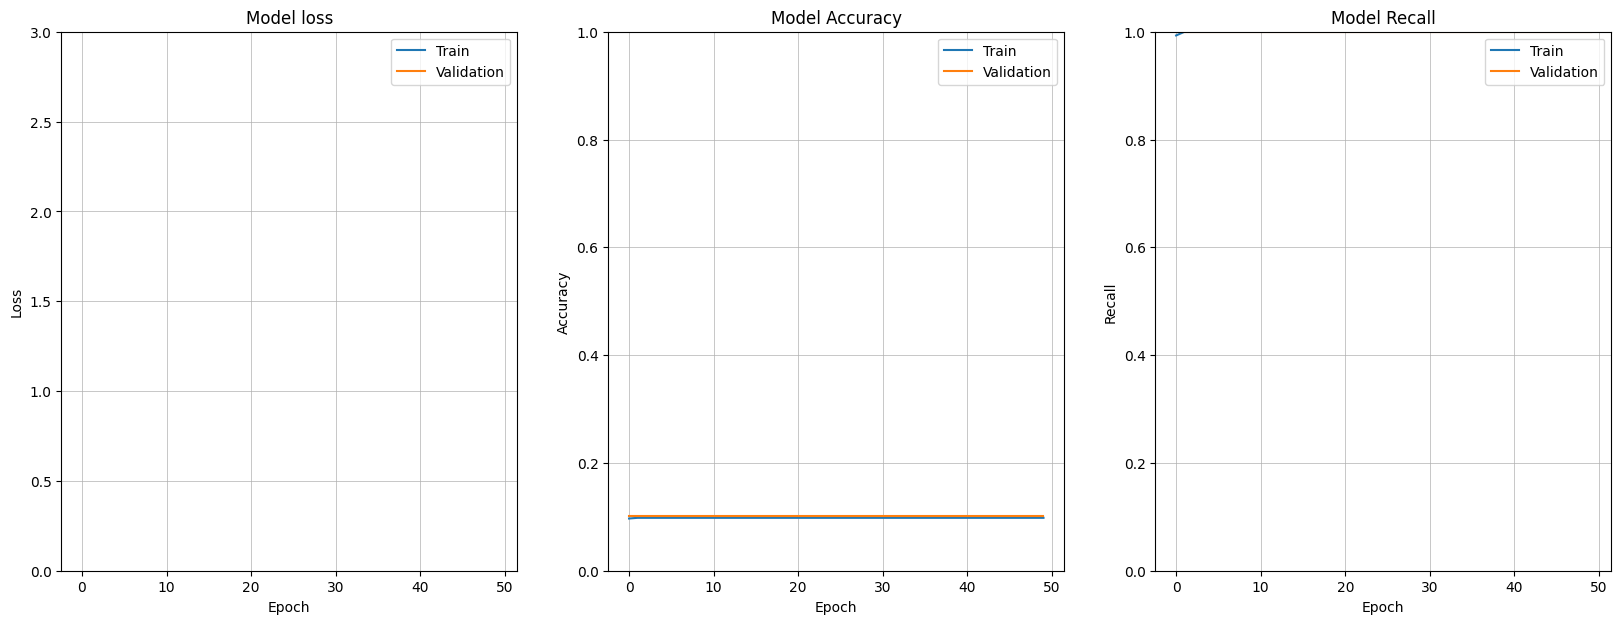

In [131]:
plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

In [132]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')

Model accuracy is 10.5 %
Model recall is 100.0 %


# Testing Normal vs Every diseases

In [137]:
labels_chondral = [1] * len(images_chondral)
labels_normal = [0] * len(images_normal)

X = np.concatenate((images_normal, images_chondral), axis=0)
y = np.concatenate((labels_normal, labels_chondral), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model = initialize_vgg16_model()
es = EarlyStopping(patience = 10, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)


Epoch 1/50
20/20 [==============================] - 4s 174ms/step - loss: 20.4526 - binary_accuracy: 0.7125 - recall: 0.7562 - val_loss: 3.0220 - val_binary_accuracy: 0.8375 - val_recall: 0.9444
Epoch 2/50
20/20 [==============================] - 3s 151ms/step - loss: 0.9409 - binary_accuracy: 0.9422 - recall: 0.9475 - val_loss: 3.2794 - val_binary_accuracy: 0.8875 - val_recall: 0.7917
Epoch 3/50
20/20 [==============================] - 3s 155ms/step - loss: 1.2386 - binary_accuracy: 0.9250 - recall: 0.9228 - val_loss: 2.3831 - val_binary_accuracy: 0.9000 - val_recall: 0.9722
Epoch 4/50
20/20 [==============================] - 3s 173ms/step - loss: 0.2062 - binary_accuracy: 0.9781 - recall: 0.9907 - val_loss: 1.5253 - val_binary_accuracy: 0.9438 - val_recall: 0.9444
Epoch 5/50
20/20 [==============================] - 3s 154ms/step - loss: 0.0229 - binary_accuracy: 0.9984 - recall: 0.9969 - val_loss: 1.9108 - val_binary_accuracy: 0.9125 - val_recall: 0.9444
Epoch 6/50
20/20 [===========

7/7 [==============================] - 1s 107ms/step - loss: 1.0672 - binary_accuracy: 0.9600 - recall: 0.9712
Model accuracy is 96.0 %
Model recall is 97.12 %


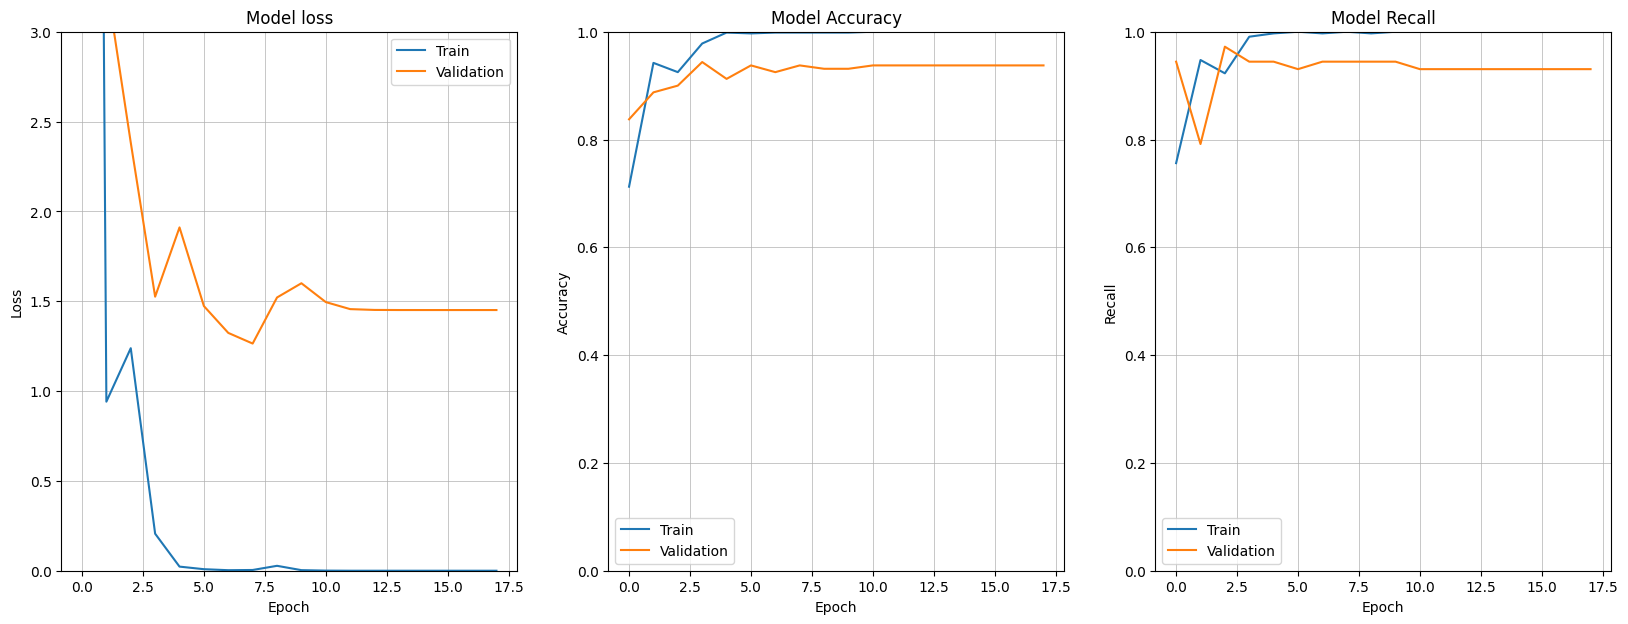

In [138]:
plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')

# Disease vs disease

Epoch 1/50
20/20 [==============================] - 6s 248ms/step - loss: 32.6278 - binary_accuracy: 0.7188 - recall: 0.6899 - val_loss: 4.7226 - val_binary_accuracy: 0.9000 - val_recall: 0.9659
Epoch 2/50
20/20 [==============================] - 3s 166ms/step - loss: 1.6646 - binary_accuracy: 0.9359 - recall: 0.9494 - val_loss: 3.6902 - val_binary_accuracy: 0.9062 - val_recall: 0.9318
Epoch 3/50
20/20 [==============================] - 3s 163ms/step - loss: 0.4639 - binary_accuracy: 0.9734 - recall: 0.9810 - val_loss: 2.9498 - val_binary_accuracy: 0.9000 - val_recall: 0.8977
Epoch 4/50
20/20 [==============================] - 3s 162ms/step - loss: 0.0678 - binary_accuracy: 0.9922 - recall: 0.9873 - val_loss: 2.9436 - val_binary_accuracy: 0.9125 - val_recall: 0.9545
Epoch 5/50
20/20 [==============================] - 3s 163ms/step - loss: 0.0082 - binary_accuracy: 0.9969 - recall: 1.0000 - val_loss: 2.7199 - val_binary_accuracy: 0.8875 - val_recall: 0.8750
Epoch 6/50
20/20 [===========

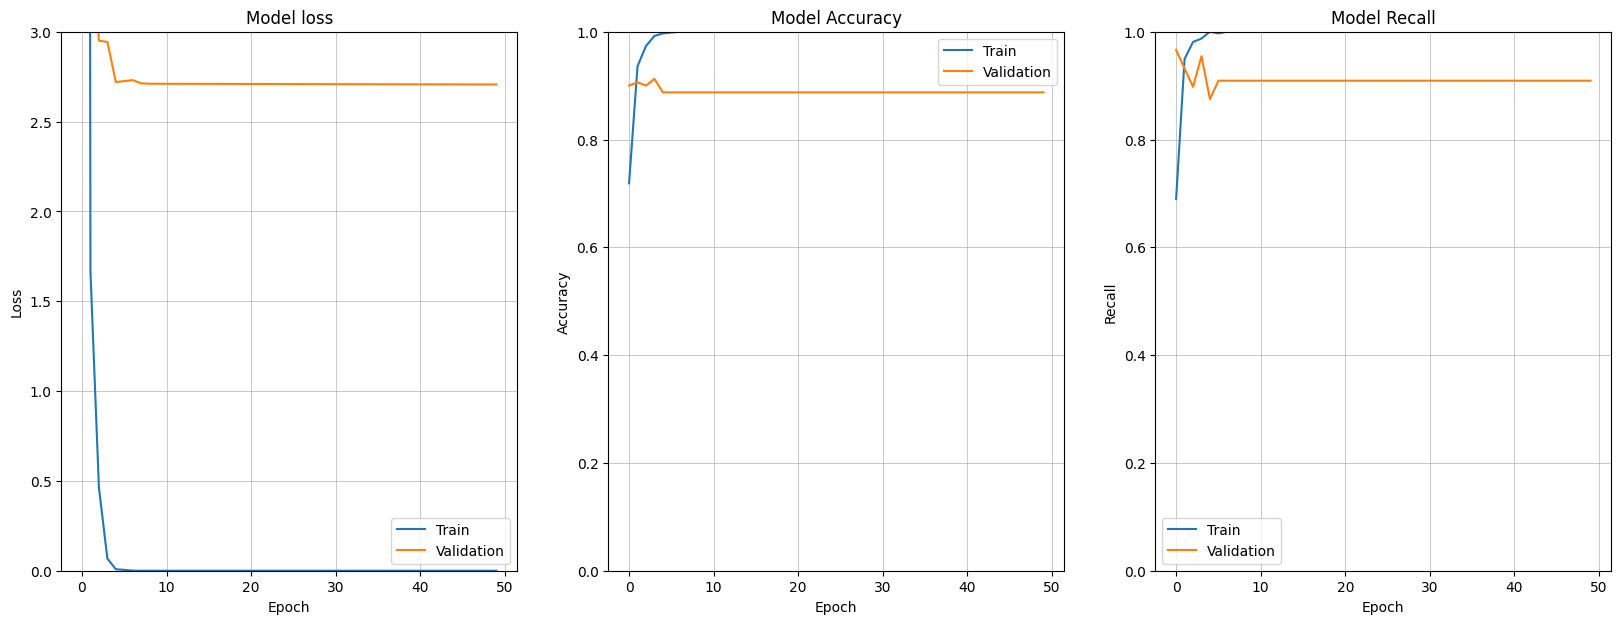

In [146]:
labels_acl = [1] * len(images_acl)
labels_inflammation = [0] * len(images_inflammation)

X = np.concatenate((images_acl, images_inflammation), axis=0)
y = np.concatenate((labels_acl, labels_inflammation), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model = initialize_vgg16_model()
es = EarlyStopping(patience = 10, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')


Epoch 1/5
10/10 [==============================] - 350s 36s/step - loss: 56.6770 - binary_accuracy: 0.5719 - recall: 0.7365 - val_loss: 9.3946 - val_binary_accuracy: 0.5500 - val_recall: 0.0270
Epoch 2/5
10/10 [==============================] - 262s 27s/step - loss: 5.9693 - binary_accuracy: 0.6313 - recall: 0.5928 - val_loss: 5.1026 - val_binary_accuracy: 0.6250 - val_recall: 0.9459
Epoch 3/5
10/10 [==============================] - 262s 27s/step - loss: 1.7094 - binary_accuracy: 0.7875 - recall: 0.7006 - val_loss: 3.3712 - val_binary_accuracy: 0.6750 - val_recall: 0.8919
Epoch 4/5
10/10 [==============================] - 261s 27s/step - loss: 0.5440 - binary_accuracy: 0.9031 - recall: 0.9820 - val_loss: 1.6158 - val_binary_accuracy: 0.7750 - val_recall: 0.6757
Epoch 5/5
4/4 [==============================] - 54s 12s/step - loss: 3.1387 - binary_accuracy: 0.6400 - recall: 0.9130
Model accuracy is 64.0 %
Model recall is 91.3 %


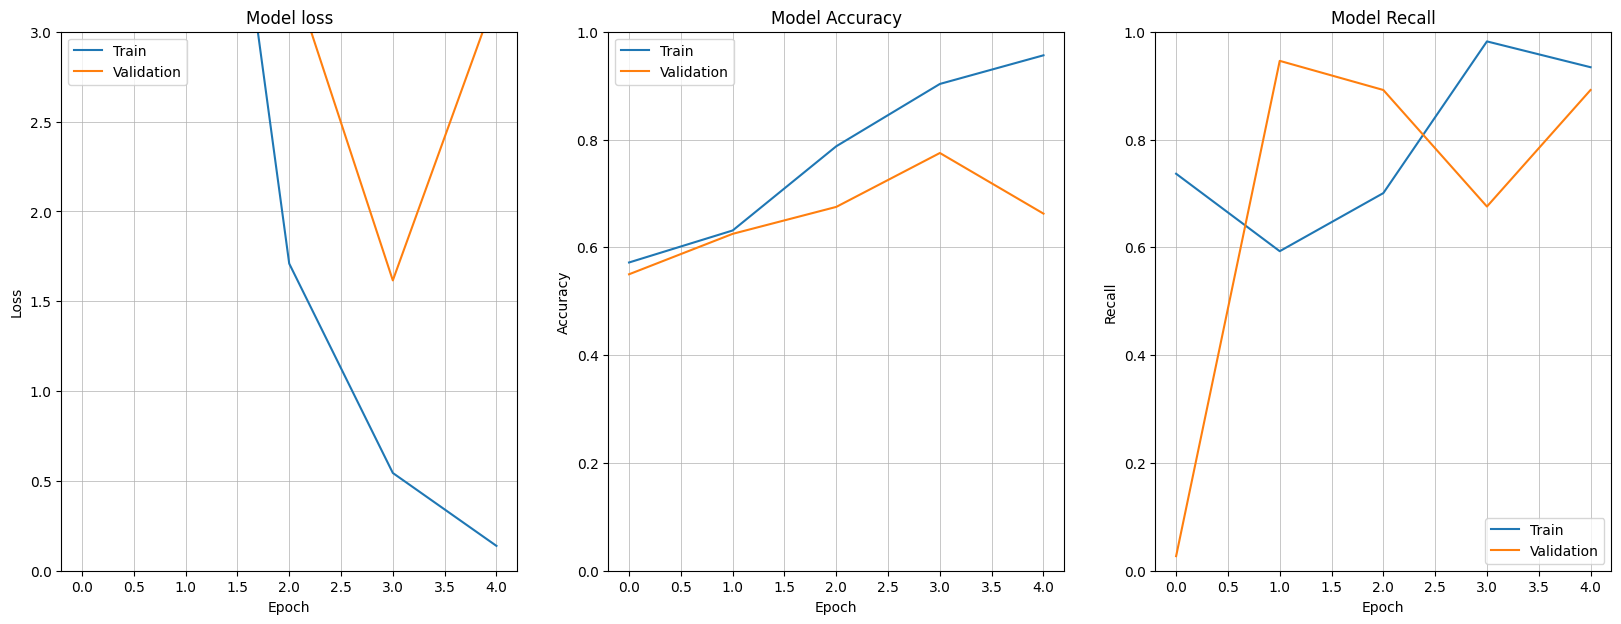

In [20]:
labels_inflammation = [1] * len(images_inflammation)
labels_chondral = [0] * len(images_chondral)

X = np.concatenate((images_inflammation, images_chondral), axis=0)
y = np.concatenate((labels_inflammation, labels_chondral), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model = initialize_vgg16_model()
es = EarlyStopping(patience = 3, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=5,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')

Epoch 1/5
10/10 [==============================] - 261s 27s/step - loss: 86.2843 - binary_accuracy: 0.4656 - recall: 0.6407 - val_loss: 1.4917 - val_binary_accuracy: 0.7500 - val_recall: 0.8378
Epoch 2/5
10/10 [==============================] - 257s 27s/step - loss: 4.1490 - binary_accuracy: 0.6438 - recall: 0.4072 - val_loss: 2.3108 - val_binary_accuracy: 0.6500 - val_recall: 0.9459
Epoch 3/5
10/10 [==============================] - 257s 27s/step - loss: 1.6122 - binary_accuracy: 0.7312 - recall: 0.9641 - val_loss: 0.9908 - val_binary_accuracy: 0.7500 - val_recall: 0.5405
Epoch 4/5
10/10 [==============================] - 261s 27s/step - loss: 0.7493 - binary_accuracy: 0.8156 - recall: 0.6766 - val_loss: 0.9352 - val_binary_accuracy: 0.7250 - val_recall: 0.9459
Epoch 5/5
4/4 [==============================] - 54s 12s/step - loss: 1.0165 - binary_accuracy: 0.7200 - recall: 0.5870
Model accuracy is 72.0 %
Model recall is 58.7 %


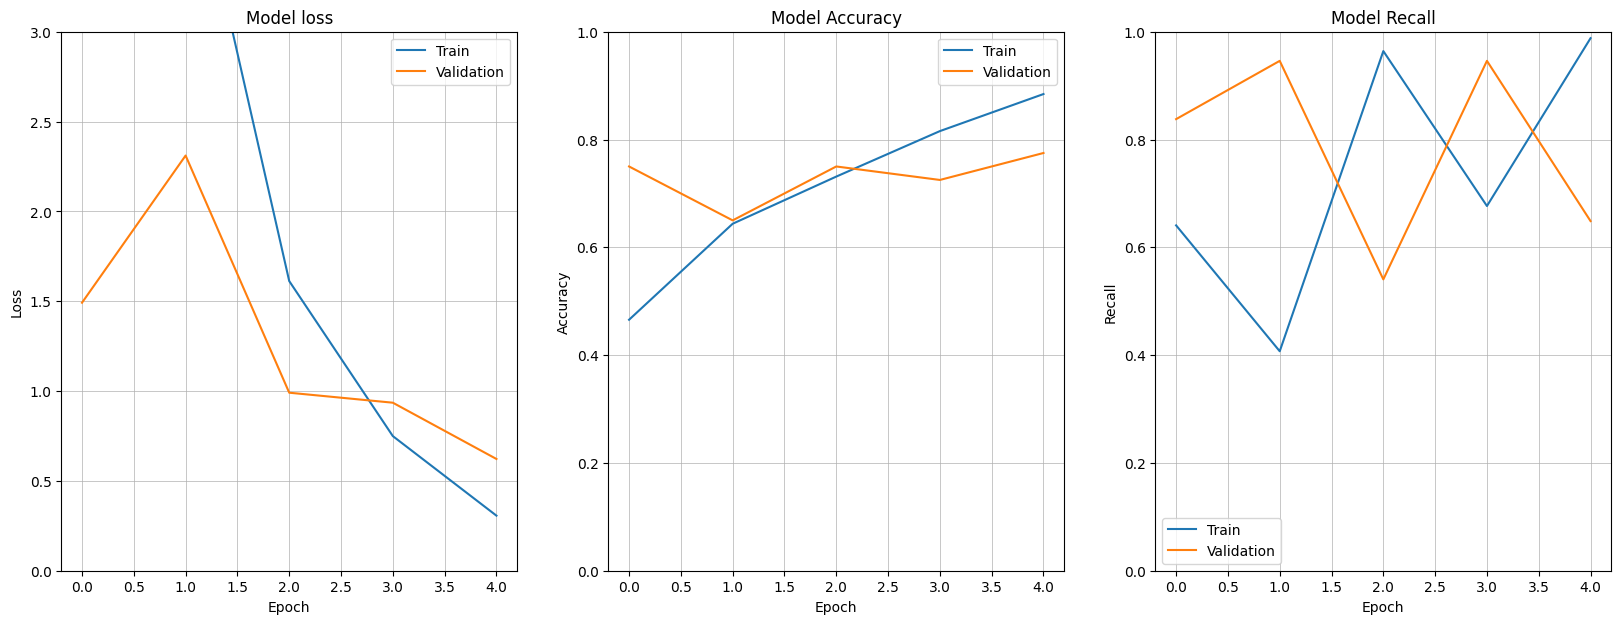

In [21]:
labels_inflammation = [1] * len(images_inflammation)
labels_fracture = [0] * len(images_fracture)

X = np.concatenate((images_inflammation, images_fracture), axis=0)
y = np.concatenate((labels_inflammation, labels_fracture), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model = initialize_vgg16_model()
es = EarlyStopping(patience = 3, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=5,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')

In [ ]:
labels_inflammation = [1] * len(images_inflammation)
labels_intra = [0] * len(images_intra)

X = np.concatenate((images_inflammation, images_intra), axis=0)
y = np.concatenate((labels_inflammation, labels_intra), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model = initialize_vgg16_model()
es = EarlyStopping(patience = 3, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=5,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')

Exception ignored in: <function _xla_gc_callback at 0x7d5449af2c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Epoch 1/5


In [23]:
labels_inflammation = [1] * len(images_inflammation)
labels_meniscal = [0] * len(images_meniscal)

X = np.concatenate((images_inflammation, images_meniscal), axis=0)
y = np.concatenate((labels_inflammation, labels_meniscal), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model = initialize_vgg16_model()
es = EarlyStopping(patience = 3, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=5,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')

Epoch 1/5
 2/10 [=====>........................] - ETA: 2:13 - loss: 27.1951 - binary_accuracy: 0.5312 - recall: 0.7188

KeyboardInterrupt: ignored

In [ ]:
labels_inflammation = [1] * len(images_inflammation)
labels_patella = [0] * len(images_patella)

X = np.concatenate((images_inflammation, images_patella), axis=0)
y = np.concatenate((labels_inflammation, labels_patella), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model = initialize_vgg16_model()
es = EarlyStopping(patience = 3, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=5,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')

In [ ]:
labels_inflammation = [1] * len(images_inflammation)
labels_pcl = [0] * len(images_pcl)

X = np.concatenate((images_inflammation, images_pcl), axis=0)
y = np.concatenate((labels_inflammation, labels_pcl), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model = initialize_vgg16_model()
es = EarlyStopping(patience = 3, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=5,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')

In [ ]:
labels_inflammation = [1] * len(images_inflammation)
labels_stfc = [0] * len(images_stfc)

X = np.concatenate((images_inflammation, images_stfc), axis=0)
y = np.concatenate((labels_inflammation, labels_stfc), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

model = initialize_vgg16_model()
es = EarlyStopping(patience = 3, restore_best_weights=True)

history = model.fit(X_train, y_train,
          epochs=5,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)

plot_loss_accuracy(history, title=None)
evaluation = model.evaluate(X_test, y_test)

print(f'Model accuracy is {round(evaluation[1]*100,2)} %')
print(f'Model recall is {round(evaluation[2]*100,2)} %')